**Install TensorFlow and Import Libraries**

In [1]:
# Installing the latest version of TensorFlow
!pip install tensorflow

# Importing libraries as needed as:-
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


**Load and Inspect the Dataset**

In [2]:
# Loading the dataset
dataset = pd.read_csv('Churn_Modelling.csv')

# Displaying the first 5 rows of the dataset for sample check
print("Dataset Head:")
print(dataset.head())

# Defining the feature matrix (X) and target vector (y)
# We drop 'RowNumber', 'CustomerId', and 'Surname' as they are not useful for prediction
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values

print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)

Dataset Head:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  

**Encode Categorical Data**

In [3]:
# Printing the original features for reference
print("Original X[0]:", X[0])

# Encoding the 'Gender' column
le = LabelEncoder()
X[:, 2] = le.fit_transform(X[:, 2])

# One Hot Encoding the 'Geography' column
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# The transformer will apply OneHotEncoder to the column at index 1 and pass through the rest
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

# Printing the transformed features to see the result
print("\nTransformed X[0] after encoding:", X[0])

Original X[0]: [619 'France' 'Female' 42 2 0.0 1 1 1 101348.88]

Transformed X[0] after encoding: [1.0 0.0 0.0 619 0 42 2 0.0 1 1 1 101348.88]


**Split Data and Apply Feature Scaling**

In [4]:
# Splitting the dataset into the Training set and Test set as:-
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling would be:-
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (8000, 12)
Test data shape: (2000, 12)


**Feature Significance Check**

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Training a random forest for feature importance as:-
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = ct.get_feature_names_out()

# Displaying feature importances
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances (Random Forest):")
print(feat_imp_df)



Feature Importances (Random Forest):
                Feature  Importance
5         remainder__x3    0.238436
11        remainder__x9    0.145639
3         remainder__x0    0.141761
7         remainder__x5    0.139219
8         remainder__x6    0.129423
6         remainder__x4    0.083866
10        remainder__x8    0.042412
1   encoder__x1_Germany    0.021573
4         remainder__x2    0.020003
9         remainder__x7    0.018782
0    encoder__x1_France    0.009800
2     encoder__x1_Spain    0.009086


**Build the Three-Layered ANN**

In [5]:
# Initialising the ANN
ann = tf.keras.models.Sequential()

# Adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu', input_dim=X_train.shape[1]))

# Adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

# Adding the output layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Printing the model summary as:-
ann.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127 (508.00 B)

 Trainable params: 127 (508.00 B)

 Non-trainable params: 0 (0.00 B)

**Compile and Train the ANN**

In [6]:
# Compiling the ANN
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the ANN on the Training set
history = ann.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7364 - loss: 0.6053
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7968 - loss: 0.4754
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7958 - loss: 0.4587
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7966 - loss: 0.4411
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8026 - loss: 0.4301
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8086 - loss: 0.4163
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8130 - loss: 0.3916
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8217 - loss: 0.3785
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8124 - loss: 0.3889
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8284 - loss: 0.3635
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8537 - loss: 0.3673
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━━━━

***Training Loss & Accuracy Curves***

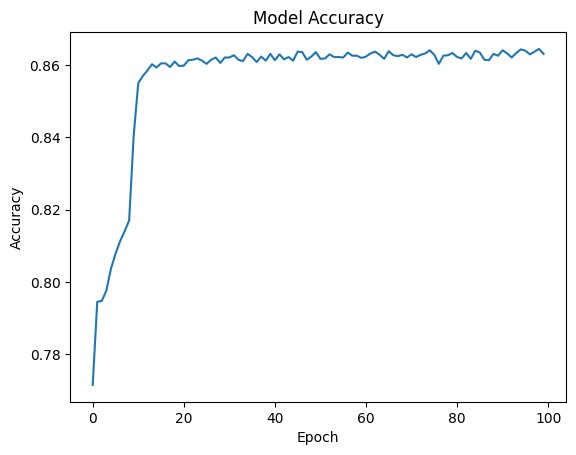

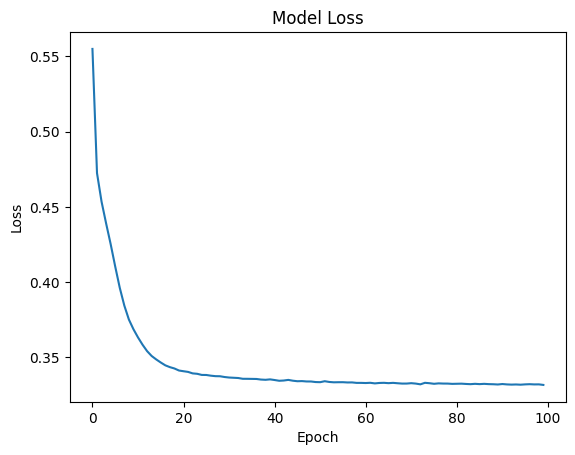

In [9]:
import matplotlib.pyplot as plt

# Plotting training accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plotting training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


**Classification Report**

In [10]:
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1607
           1       0.71      0.50      0.59       393

    accuracy                           0.86      2000
   macro avg       0.80      0.73      0.75      2000
weighted avg       0.85      0.86      0.85      2000



**Make Predictions and Evaluate the Model**

In [7]:
# Predicting the Test set results
y_pred_prob = ann.predict(X_test)
y_pred = (y_pred_prob > 0.5)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("-----------------------------------------")
print("Model Evaluation on Test Data")
print("-----------------------------------------")
print("Confusion Matrix:\n", cm)
print("\nAccuracy Score: {:.2f}%".format(acc * 100))
print("-----------------------------------------")

# interpreting the confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Correctly predicted Non-Churn): {tn}")
print(f"False Positives (Incorrectly predicted Churn): {fp}")
print(f"False Negatives (Incorrectly predicted Non-Churn): {fn}")
print(f"True Positives (Correctly predicted Churn): {tp}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
-----------------------------------------
Model Evaluation on Test Data
-----------------------------------------
Confusion Matrix:
 [[1528   79]
 [ 195  198]]

Accuracy Score: 86.30%
-----------------------------------------

True Negatives (Correctly predicted Non-Churn): 1528
False Positives (Incorrectly predicted Churn): 79
False Negatives (Incorrectly predicted Non-Churn): 195
True Positives (Correctly predicted Churn): 198


**Save & Reload Model**

In [11]:

ann.save('bank_churn_model.h5')


from tensorflow.keras.models import load_model
loaded_model = load_model('bank_churn_model.h5')
print("Model reloaded successfully.")


Model reloaded successfully.


**Predict for a Single Customer**

In [12]:
# Predicting for first test sample
sample = X_test[0].reshape(1, -1)
prediction = ann.predict(sample)
print("Churn Probability:", prediction[0][0])
print("Predicted Class:", int(prediction[0][0] > 0.5))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Churn Probability: 0.077435754
Predicted Class: 0


**K-Fold Cross-Validation for ANN**

In [13]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for train_idx, test_idx in kf.split(X, y):
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    X_train_fold = sc.fit_transform(X_train_fold)
    X_test_fold = sc.transform(X_test_fold)

    ann_cv = tf.keras.models.Sequential([
        tf.keras.layers.Dense(6, activation='relu', input_dim=X_train_fold.shape[1]),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    ann_cv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    ann_cv.fit(X_train_fold, y_train_fold, batch_size=32, epochs=50, verbose=0)

    _, acc = ann_cv.evaluate(X_test_fold, y_test_fold, verbose=0)
    fold_accuracies.append(acc)

print(f"Cross-validation Accuracies: {fold_accuracies}")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Cross-validation Accuracies: [0.8560000061988831, 0.8519999980926514, 0.8640000224113464, 0.8579999804496765, 0.8565000295639038]
Mean Accuracy: 0.8573
